In [46]:
# !pip install langchain==0.0.191
# !pip install openai
# !pip install xgboost
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib

In [42]:
import xgboost as xgb
import pandas as pd
import numpy as np
from collections import defaultdict
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder, 
    SystemMessagePromptTemplate, 
    HumanMessagePromptTemplate
)
from langchain.chains import ConversationChain
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from langchain.memory import ConversationBufferMemory

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
# from termcolor import colored
import os
# from flaml import tune
# from flaml import AutoML
import scipy
import re
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows

In [19]:
df = pd.read_csv("/Users/tushitdave/Desktop/AutomL-GPT/dataset/attrition_final.csv")
df.drop(['Unnamed: 0'] , axis = 1 , inplace = True)
first_column = df.pop('Attrition') 
df['Attrition'] = first_column 
df.head()

,Gender,OverTime,SalesDpt,JobInvCut,MiddleTraining,MoovingPeople,NotSatif,LongDisWL1,LongDis,LongDisJobS1,LongDisJL1,ShortDisNotSingle,LongDisSingle,Engaged,YoungAndBadPaid,YoungNeverEngaged,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,RelationshipSatisfaction_1,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,TrainingTimesLastYear_0,TrainingTimesLastYear_1,TrainingTimesLastYear_2,TrainingTimesLastYear_3,TrainingTimesLastYear_4,TrainingTimesLastYear_5,TrainingTimesLastYear_6,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,RelSatisf_mean_1.0,RelSatisf_mean_1.5,RelSatisf_mean_2.0,RelSatisf_mean_2.5,RelSatisf_mean_3.0,RelSatisf_mean_3.5,RelSatisf_mean_4.0,JobSatisf_mean_1.0,JobSatisf_mean_1.5,JobSatisf_mean_2.0,JobSatisf_mean_2.5,JobSatisf_mean_3.0,JobSatisf_mean_3.5,JobSatisf_mean_4.0,DailyRate,HourlyRate,MonthlyRate,PercentSalaryHike,TotalWorkingYears,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,TotalSatisfaction_mean,Time_in_each_comp,Income_Distance,Hrate_Mrate,Stability,Income_YearsComp,Fidelity,Attrition
0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.742527,1.383138,0.726020,-1.150554,-0.421642,-0.063296,-0.679146,0.245834,-1.238894,-0.774273,1.328107,-0.330471,0.223486,-0.241733,1.775509,1
1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,-1.297775,-0.240677,1.488876,2.129306,-0.164511,0.764998,-0.368715,0.806541,0.161650,1.578035,-0.451684,-0.715919,0.328996,-0.473382,-0.620450,0
2,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1.414363,1.284725,-1.674841,-0.057267,-0.550208,-1.167687,-0.679146,-1.155935,0.161650,-0.755860,-0.317412,5.114320,0.000000,-0.717985,1.395198,1
3,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1.461466,-0.486709,1.243211,-1.150554,-0.421642,0.764998,0.252146,-1.155935,1.095346,0.031312,-0.342465,-0.720954,0.882920,-0.544605,-0.553896,0
4,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,-0.524295,-1.274014,0.325900,-0.877232,-0.678774,-0.615492,-0.058285,-0.595227,-0.305198,-1.090062,-0.088277,-0.723072,1.278581,0.108800,3.106597,0


In [118]:
df.shape

(2940, 111)

In [20]:
feature_names = defaultdict(list)
with open('/Users/tushitdave/Desktop/AutomL-GPT/dataset/attrition_features_data.txt', 'r') as f:
    for line in f.readlines():
        feature, category = line.strip().strip('.').split(': ')
        feature_names[category].append(feature)

num_feats = feature_names['continuous']
nom_feats = feature_names['descrete']

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [22]:
X_train = train.iloc[:, :-1].to_numpy()
y_train = train['Attrition'].to_numpy()

X_test = test.iloc[:, :-1].to_numpy()
y_test = test['Attrition'].to_numpy()

In [23]:
import json
with open('/Users/tushitdave/Desktop/AutomL-GPT/open_ai_key_mngt/key.json') as config_file:
    config = json.load(config_file)
    api_key = config['api_key']

In [24]:
def initialize_chat_openai(openai_api_key, temperature):

    llm = ChatOpenAI(temperature=temperature, openai_api_key=openai_api_key)
    memory = ConversationBufferMemory(return_messages=True)
    return llm, memory

# Example usage:
api_key = api_key
llm, memory = initialize_chat_openai(api_key, temperature=0.5)


In [25]:
def data_report(df, num_feats, nom_feats):
   
    # Last column is the label
    target = df.iloc[:, -1]
    features = df.iloc[:, :-1]

    # General dataset info
    num_instances = len(df)
    num_features = features.shape[1]

    # Label class analysis
    class_counts = target.value_counts()
    class_distribution = class_counts / num_instances
    if any(class_distribution < 0.3) or any(class_distribution > 0.7):
        class_imbalance = True
    else:
        class_imbalance = False

    # Create a text report
    report = f"""Data Characteristics Report:

- General information:
  - Number of Instances: {num_instances}
  - Number of Features: {num_features}

- Class distribution analysis:
  - Class Distribution: {class_distribution.to_string()}
  {'Warning: Class imbalance detected.' if class_imbalance else ''}

- Feature analysis:
  - Feature names: {features.columns.to_list()}
  - Number of numerical features: {len(num_feats)}
  - Number of nominal features: {len(nom_feats)}
  - Nominal feature names: {nom_feats}
"""
   
    return report


In [26]:
report = data_report(df, num_feats, nom_feats)

#### Prompt for finding best hyper-parameters and scores

In [27]:
# Setting up a system message
system_message = f"""
As a senior data scientist, your responsibility is to lead the utilization of an AutoML tool 
in the pursuit of identifying optimal XGBoost model configurations for a specific binary classification 
dataset. Your pivotal role encompasses a comprehensive understanding of the dataset's unique attributes, 
the proposal of appropriate evaluation metrics, definition of hyperparameters, and the delineation of their 
search ranges. Moreover, you are tasked with in-depth analysis of the obtained results and the iterative 
refinement of model configurations to achieve the best possible outcomes. Your expertise will be instrumental 
in achieving success in this endeavor.
"""

In [28]:
def suggest_metrics(report):
    
    prompt = f"""
        Our mission is to tackle a classification problem utilizing a HR Attrition dataset from IBM. 
        This dataset presents us with two critical classes: "No-Attrition" (label: 0), indicating individuals 
        with no intention to leave the organization, and "Yes-Attrition" (label: 1), signifying individuals 
        inclined towards leaving the organization. 

        To shed light on this dataset, here are some of its pivotal characteristics:
        {report}.

        Your precise objective is to propose a hyperparameter optimization metric ideally suited for training 
        an XGBoost model. The utmost priority is for the model to adeptly discern instances of genuine 
        attrition (i.e., 'Yes-Attrition') while minimizing the generation of false positives on non-attrition 
        cases (i.e., 'No-Attrition'). 

        In light of the context and the dataset's unique features, kindly recommend one of the following 
        built-in metrics, tailored for this specific task:
        - 'accuracy'
        - 'roc_auc' (Receiver Operating Characteristic Area Under the Curve score)
        - 'f1' (F1 score)
        - 'balanced_accuracy' (This metric calculates the average recall score per class, providing a fair 
          evaluation, especially in the presence of class imbalance)
        - 'average_precision'
        - 'precision'
        - 'recall'
        - 'neg_brier_score'

        Please preface your response with a succinct explanation of your selection rationale. Subsequently, 
        provide the name of your recommended metric, encapsulated between the markers [BEGIN] and [END], 
        as a standalone string.
        We kindly request that you do not share additional settings or configurations.
    """

    return prompt

In [29]:
def suggest_initial_search_space():
    
    prompt = f"""
        Leveraging your deep understanding of XGBoost and established machine learning best practices, 
        your primary objective is to propose a precise initial hyperparameter search space.

        The tunable hyperparameters include:
        - n_estimators (integer): The number of boosting rounds or trees to be trained. Consider 
          values between 50 and 300.
        - max_depth (integer): The maximum depth allowed for individual trees. Suggest values 
          within the range of 3 to 15.
        - min_child_weight (integer or float): The minimum sum of instance weight (hessian) 
          required in a leaf node. Recommend values between 1 and 10.
        - gamma (float): The minimum loss reduction required to perform an additional partition 
          on a leaf node of the tree. Suggest values between 0.0 and 0.3.
        - scale_pos_weight (float): A parameter used to balance positive and negative weights. 
          Propose values near 1.0.
        - learning_rate (float): The step size shrinkage applied during each boosting round to 
          mitigate overfitting. Consider values from 0.01 to 0.3.
        - subsample (float): The fraction of training data randomly sampled to train each tree. 
          Recommend values between 0.6 and 0.9.
        - colsample_bylevel (float): The fraction of features that can be randomly sampled for 
          constructing each level (or depth) of the tree. Suggest values near 0.8.
        - colsample_bytree (float): The fraction of features that can be randomly sampled for 
          building each tree. Propose values near 0.8.
        - reg_alpha (float): The strength of L1 regularization applied to weights. Consider values 
          between 0.0 and 1.0.
        - reg_lambda (float): The strength of L2 regularization applied to weights. Recommend values 
          between 0.0 and 1.0.

        To define the search space, construct a dictionary where keys represent hyperparameter names, 
        and values represent their respective search space definitions. For example:
            search_space = {{
                "learning_rate": loguniform(1e-4, 1e-3)
            }}

        You have access to various domain types:
        - scipy.stats.uniform(loc, scale): Samples values uniformly between loc and loc + scale.
        - scipy.stats.loguniform(a, b): Samples values between a and b on a logarithmic scale.
        - scipy.stats.randint(low, high): Samples integers uniformly between low (inclusive) and high (exclusive).
        - A list of possible discrete values, e.g., ["a", "b", "c"]

        Begin by offering a concise rationale for your choices, and then provide specific hyperparameter 
        configurations for the initial search space. Your recommended configurations should be enclosed 
        between the markers [BEGIN] and [END], and you should assign your search space to a variable named 
        search_space.
    """

    return prompt

In [30]:
last_run_best_score = []
all_time_best_score = []

In [119]:
def suggest_refine_search_space(top_n, last_run_best_score, all_time_best_score):

    prompt = f"""
    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    {top_n}
    
    The best score from the last run was {last_run_best_score}, while the best score ever 
    achieved in all previous runs is {all_time_best_score}

    Remember, tunable hyperparameters are: n_estimators, max_depth, min_child_samples, gamma, 
    scale_pos_weight, learning_rate, subsample, colsample_bylevel, colsample_bytree, reg_alpha, 
    and reg_lambda.

    Given the insights from the search history, your expertise in ML, and the need to further 
    explore the search space, please suggest refinements for the search space in the next optimization round. 
    Consider both narrowing and expanding the search space for hyperparameters where appropriate.

    For each recommendation, please:
    1. Explicitly tie back to any general best practices or patterns you are aware of regarding XGBoost tuning
    2. Then, relate to the insights from the search history and explain how they align or deviate from these 
    practices or patterns.
    3. If suggesting an expansion of the search space, please provide a rationale for why a broader range could 
    be beneficial.


    Briefly summarize your reasoning for the refinements and then present the adjusted configurations. 
    Enclose your refined configurations between markers [BEGIN] and [END], and assign your 
    configuration to a variable named search_space.
    """
    
    return prompt

In [32]:
#My templates
system_template = SystemMessagePromptTemplate.from_template(system_message)
human_template = HumanMessagePromptTemplate.from_template("""{input}""")
message_placeholder = MessagesPlaceholder(variable_name="history")

# list of prompt templates
prompt_templates = [system_template, message_placeholder, human_template]

#ChatPromptTemplate from the list of templates
prompt = ChatPromptTemplate.from_messages(prompt_templates)

# conversation chain
conversation = ConversationChain(memory=memory, prompt=prompt, llm=llm, verbose=False)


In [94]:
# conversation

In [34]:
# Suggest metrics
prompt = suggest_metrics(report)
response = conversation.predict(input=prompt)
print(response)

Based on the given dataset and the objective of minimizing false positives while accurately identifying instances of attrition, the most suitable evaluation metric would be the 'precision' metric.

Precision is a metric that measures the proportion of true positive predictions out of all positive predictions made by the model. In the context of attrition prediction, precision would indicate the ability of the model to correctly identify individuals who are likely to leave the organization (positive class) while minimizing the misclassification of individuals who are not likely to leave (negative class).

Since the dataset has a class imbalance, with a majority of instances belonging to the 'No-Attrition' class, precision would be a more appropriate metric than accuracy. Accuracy can be misleading in the presence of class imbalance as it tends to favor the majority class.

Therefore, the recommended evaluation metric for this task is 'precision'.

[BEGIN]
'precision'
[END]


In [35]:
# Initial search space
prompt = suggest_initial_search_space()
response = conversation.predict(input=prompt)
print(response)

When defining the initial search space for hyperparameters, it is important to consider a range of values that are likely to yield good model performance while avoiding extreme values that may lead to overfitting or underfitting. Here is the rationale behind the choices for each hyperparameter:

- n_estimators: It represents the number of boosting rounds or trees to be trained. A higher number of trees can capture more complex patterns in the data but may also increase the risk of overfitting. Therefore, a moderate range of values between 50 and 300 is considered.

- max_depth: It controls the maximum depth of each tree. A higher depth allows the model to capture more complex interactions but can also lead to overfitting. A range of 3 to 15 is chosen to allow for a moderate level of complexity.

- min_child_weight: It sets the minimum sum of instance weight required in a leaf node. A higher value can help prevent overfitting by requiring a minimum number of samples in each leaf. Values

In [36]:
search_space = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 15),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0.0, 0.3),
    "scale_pos_weight": [1.0],
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.9),
    "colsample_bylevel": uniform(0.8, 0.1),
    "colsample_bytree": uniform(0.8, 0.1),
    "reg_alpha": uniform(0.0, 1.0),
    "reg_lambda": uniform(0.0, 1.0)
}

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)
# search = RandomizedSearchCV(clf, search_space, scoring='roc_auc', 
#                             n_iter=5, cv=5, verbose=1).fit(X_train, y_train)
search = HalvingRandomSearchCV(clf, search_space, scoring='precision', n_candidates=500,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2352
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 20
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 60
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 180
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 540
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 1620
Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    f1_score,
    matthews_corrcoef
)

In [52]:
def metrics_display(y_test, y_pred, y_pred_proba):

    # Obtain confusion matrix
    cm = confusion_matrix(y_test, y_pred)
   
    # Output classification metrics
    tn, fp, fn, tp = cm.ravel()
   
    print(f'ROC_AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}')
    print(f'f1 score: {f1_score(y_test, y_pred):.3f}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Precision: {precision_score(y_test, y_pred)*100:.2f}%')
    print(f'Detection rate: {recall_score(y_test, y_pred)*100:.2f}%')
    print(f'False alarm rate: {fp / (tn+fp)*100}%')
    print(f'MCC: {matthews_corrcoef(y_test, y_pred):.2f}')
   
    # Display confusion matrix
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='.5g', colorbar=False)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

ROC_AUC score: 0.973
f1 score: 0.783
Accuracy: 93.88%
Precision: 97.01%
Detection rate: 65.66%
False alarm rate: 0.408997955010225%
MCC: 0.77


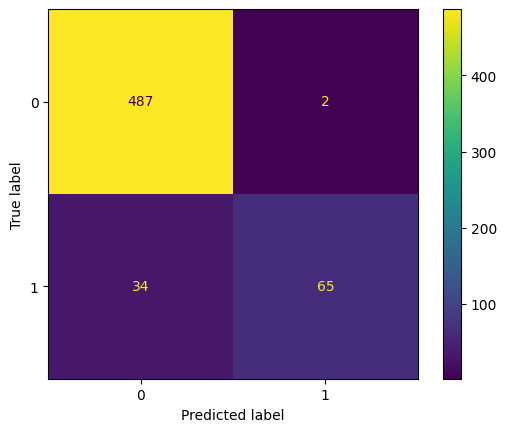

In [53]:
import matplotlib.pyplot as plt

y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)

metrics_display(y_test, y_pred, y_pred_proba[:, 1])

In [54]:
def extract_logs(results):

    # Assuming you have the logs in a DataFrame called df
    df = pd.DataFrame(search.cv_results_)

    # Number of top-performing configurations you want to extract
    top_n = 5

    # 1. Identify top-performing configurations using rank_test_score
    top_configs = df.nsmallest(top_n, 'rank_test_score').reset_index(drop=True)

    hyperparameter_columns = [
        'param_colsample_bylevel', 'param_colsample_bytree', 'param_gamma',
        'param_learning_rate', 'param_max_depth', 'param_min_child_weight',
        'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
        'param_scale_pos_weight', 'param_subsample'
    ]

    # Extracting the top-N configurations as strings
    config_strings = []
    for index, row in top_configs.iterrows():
        config_str = ', '.join([f"{col[6:]}: {row[col]}" for col in hyperparameter_columns])
        config_strings.append(f"Configuration {index + 1} ({row['mean_test_score']:.4f} test score): {config_str}")

    # Joining them together for a complete summary
    top_config_summary = '\n'.join(config_strings)
    
    # Best test score
    last_run_best_score = top_configs.loc[0, 'mean_test_score']
    
    return top_config_summary, last_run_best_score

In [56]:
# print(top_n)

In [57]:
top_n, best_score = extract_logs(search.cv_results_)
last_run_best_score.append(best_score)
# print(last_run_best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
        print(all_time_best_score)
prompt = suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])

In [58]:
prompt

'\n    User: Suggest refinements for the search space.\n\n    Given your previously suggested search space, the obtained top configurations with their \n    test scores:\n    Configuration 1 (0.9378 test score): colsample_bylevel: 0.8780308285092921, colsample_bytree: 0.8684202668791412, gamma: 0.24552123220078692, learning_rate: 0.04435393326418533, max_depth: 12, min_child_weight: 1, n_estimators: 66, reg_alpha: 0.7446950658405149, reg_lambda: 0.1333538045388577, scale_pos_weight: 1.0, subsample: 0.6023793653810001\nConfiguration 2 (0.9207 test score): colsample_bylevel: 0.8780308285092921, colsample_bytree: 0.8684202668791412, gamma: 0.24552123220078692, learning_rate: 0.04435393326418533, max_depth: 12, min_child_weight: 1, n_estimators: 66, reg_alpha: 0.7446950658405149, reg_lambda: 0.1333538045388577, scale_pos_weight: 1.0, subsample: 0.6023793653810001\nConfiguration 3 (0.9113 test score): colsample_bylevel: 0.8130619805053185, colsample_bytree: 0.8010086304279191, gamma: 0.1173

In [59]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from collections import deque

# Define your initial prompt
initial_prompt = suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])

# Initialize the RecursiveCharacterTextSplitter
chunk_size = 300
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len)

# Split the initial prompt into chunks
prompt_chunks = text_splitter.split_text(initial_prompt)

# Initialize a deque to store chunks
chunk_queue = deque(prompt_chunks)

# Initialize variables to keep track of total token count
total_tokens = 0

# Process chunks one by one in the conversation
while chunk_queue:
    # Get the next chunk
    chunk = chunk_queue.popleft()

    # Check if adding this chunk would exceed the token limit
    if total_tokens + len(chunk.split()) <= 4097:
        total_tokens += len(chunk.split())

        # Create a conversation prompt with the chunk
        conversation_prompt = f"""
        {chunk}
        """

        # Use the conversation to process the chunk
        response = conversation.predict(input=conversation_prompt)

        # Print or process the response as needed
        print(response)
    else:
        print("Chunk exceeds token limit and will be skipped.")

# All chunks have been processed
print("All chunks processed.")


To refine the search space, we can focus on narrowing down the ranges for some of the hyperparameters based on the dataset characteristics and domain knowledge. Here are the suggested refinements for the search space:

- n_estimators: Since the dataset is not very large, we can reduce the upper limit of the range to avoid overfitting. Let's update the range to be between 50 and 200.

- max_depth: We can further narrow down the range to focus on less complex trees and reduce the risk of overfitting. Let's update the range to be between 3 and 10.

- min_child_weight: We can keep the range as it is since it already covers a reasonable range of values.

- gamma: We can reduce the upper limit of the range to control the complexity of the model. Let's update the range to be between 0.0 and 0.2.

- learning_rate: We can reduce the upper limit of the range to avoid very high learning rates that may lead to overfitting. Let's update the range to be between 0.01 and 0.2.

- subsample: We can nar

InvalidRequestError: This model's maximum context length is 4097 tokens. However, your messages resulted in 4221 tokens. Please reduce the length of the messages.

This error we have received since we have good amount of features 111. If we will apply feature importance and reduce the number of features.. we wont receive this error.

In [61]:
search_space = {
    "n_estimators": randint(50, 200),
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0.0, 0.2),
    "scale_pos_weight": [1.0],
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.2),
    "colsample_bylevel": uniform(0.8, 0.1),
    "colsample_bytree": uniform(0.8, 0.1),
    "reg_alpha": uniform(0.0, 1.0),
    "reg_lambda": uniform(0.0, 1.0)
}

In [62]:
from xgboost import XGBClassifier

clf = XGBClassifier(seed=42, objective='binary:logistic', eval_metric='logloss', n_jobs=-1, use_label_encoder=False)

search = RandomizedSearchCV(estimator=clf, param_distributions=search_space, 
                            scoring='precision', n_iter=500, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)


n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2352
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 20
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 60
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 180
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 540
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 1620
Fitting 5 folds for each of 7 candidates, totalling 35 fits


ROC_AUC score: 0.984
f1 score: 0.921
Accuracy: 97.45%
Precision: 95.65%
Detection rate: 88.89%
False alarm rate: 0.81799591002045%
MCC: 0.91


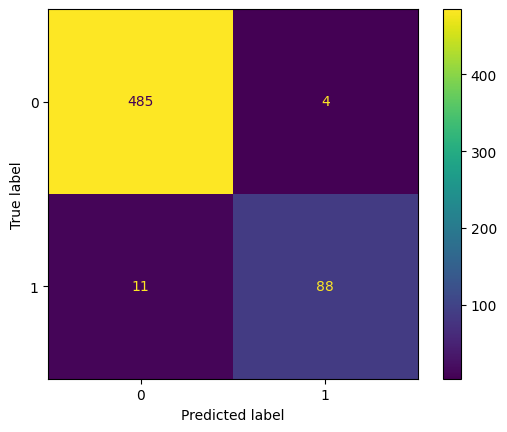

In [63]:
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
metrics_display(y_test, y_pred, y_pred_proba[:, 1])

In [114]:
def suggest_refine_search_space(top_n, last_run_best_score, all_time_best_score):
    prompt = f"""
    Based on your previous search results:

    - The top configurations and their test scores:
      {top_n}
    
    - The best score from the last run: {last_run_best_score}
    
    - The all-time best score achieved: {all_time_best_score}

    You have the opportunity to refine your search space for hyperparameters in the next optimization round.

    Consider:
    - Narrowing down the range for hyperparameters where you have observed promising results.
    - Expanding the search space for hyperparameters that have not been explored thoroughly.

    For each recommendation, please:
    1. Align it with established best practices for XGBoost tuning.
    2. Explain how it connects with insights from the search history or if it deviates.
    3. Justify any expansions in the search space.

    Summarize your refinements and provide the adjusted configurations enclosed between [BEGIN] and [END].
    Assign these configurations to a variable named search_space.
    """
    
    return prompt


In [120]:
top_n, best_score = extract_logs(search.cv_results_)
last_run_best_score.append(best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
initial_prompt = suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])

In [121]:
print(initial_prompt)


    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    Configuration 1 (0.9298 test score): colsample_bylevel: 0.8309760941328735, colsample_bytree: 0.8537432923899912, gamma: 0.04482443831024017, learning_rate: 0.06388538501858518, max_depth: 8, min_child_weight: 1, n_estimators: 172, reg_alpha: 0.8746956364521615, reg_lambda: 0.6154126868343739, scale_pos_weight: 1.0, subsample: 0.7075385114839017
Configuration 2 (0.9200 test score): colsample_bylevel: 0.8540700531340941, colsample_bytree: 0.8456405778557319, gamma: 0.06260846048244088, learning_rate: 0.12259068069659926, max_depth: 9, min_child_weight: 1, n_estimators: 165, reg_alpha: 0.9369074018099526, reg_lambda: 0.7712793610447116, scale_pos_weight: 1.0, subsample: 0.792177543072597
Configuration 3 (0.9106 test score): colsample_bylevel: 0.8558554393088075, colsample_bytree: 0.8078694055580627, gamma: 0.041671456712256805, learning_rate: 0.08219856657586323, max_depth: